### Project Structure

6. [**Model Training**](#sixth): Utilize machine learning algorithms to df a predictive model on the dfing data.
7. [**Model Evaluation**](#seventh): Evaluate the dfed model's performance using appropriate metrics and techniques.
8. [**Summary**](#eighth): Summary and future scope of the project
9. [**References**](#ninth): References, websites which I have used to complete this project

### Libraries

In [2]:
import os
import time

# Ignore Warnings
import warnings

#data Manipulations
import pandas as pd
import numpy as np
from scipy import stats

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas

%matplotlib inline

# Data Transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Feature Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

# Models/Algorithms
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Metrics
import math
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from tqdm import tqdm

import joblib

warnings.filterwarnings('ignore')  # Disabling warning outputs

In [3]:
### Load data

save_directory = os.path.join('processed_data')

try:
    X_train = pd.read_csv(os.path.join(save_directory, 'X_train.csv'))
    X_test = pd.read_csv(os.path.join(save_directory, 'X_test.csv'))
    y_train = pd.read_csv(os.path.join(save_directory, 'y_train.csv')) #.squeeze() # .squeeze() to convert back to Series
    y_test = pd.read_csv(os.path.join(save_directory, 'y_test.csv'))# .squeeze()
    
    print(f"Loaded X_train shape: {X_train.shape}")
    print(f"Loaded y_train shape: {y_train.shape}")
    print("Data loaded successfully!")
except Exception as e:
    print(f"An error occurred while loading: {e}")

Loaded X_train shape: (1037340, 7)
Loaded y_train shape: (1037340, 1)
Data loaded successfully!


In [3]:
def map_genders(df):
    gender_mapping = {'M': 0, 'F': 1} # Or you could use {'M': 1, 'F': 0}

    # Apply the mapping directly to the 'gender' column in both training and testing sets
    df['gender'] = df['gender'].map(gender_mapping)
    return df

In [4]:
def fit_and_save_ohe(df, column='category', encoder_path='artifacts/category_ohe.pkl'):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe.fit(df[[column]])
    joblib.dump(ohe, encoder_path)
    ohe_features = ohe.transform(df[[column]])
    ohe_df = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out([column]), index=df.index)
    return pd.concat([df.drop(columns=[column]), ohe_df], axis=1)


In [5]:
X_train = map_genders(X_train)
X_train = fit_and_save_ohe(X_train)
X_train.shape

(1037340, 20)

In [6]:
def load_and_transform_ohe(df, column='category', encoder_path='artifacts/category_ohe.pkl'):
    ohe = joblib.load(encoder_path)
    ohe_features = ohe.transform(df[[column]])
    ohe_df = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out([column]), index=df.index)
    return pd.concat([df.drop(columns=[column]), ohe_df], axis=1)

In [7]:
X_test = map_genders(X_test)
X_test = load_and_transform_ohe(X_test)
X_test.shape

(259335, 20)

# <a id='sixth'></a> Model Training

In [8]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

## Neural Network using tensorflow

In [9]:
# 1. Define the Neural Network Model
def build_nn_model(input_shape, learning_rate=0.001):
    """
    Builds a simple Sequential Neural Network model for binary classification.

    Args:
        input_shape (int): The number of input features (columns) in your data.
        learning_rate (float): The learning rate for the Adam optimizer.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    model = keras.Sequential([
        # Input Layer: Defines the expected shape of the input data.
        keras.Input(shape=(input_shape,)),

        # Hidden Layer 1: Dense (fully connected) layer with ReLU activation.
        # 128 units is a common starting point; adjust as needed.
        layers.Dense(128, activation='relu', name='hidden_layer_1'),
        layers.BatchNormalization(), # Optional: Helps with training deeper networks
        layers.Dropout(0.3),         # Optional: Prevents overfitting

        # Hidden Layer 2: Another Dense layer.
        # 64 units is a common choice; adjust as needed.
        layers.Dense(64, activation='relu', name='hidden_layer_2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Output Layer: Single neuron with sigmoid activation for binary classification.
        # Sigmoid outputs a probability between 0 and 1.
        layers.Dense(1, activation='sigmoid', name='output_layer')
    ])

    # 2. Compile the Model
    # Optimizer: Adam is a good general-purpose optimizer.
    # Loss: 'binary_crossentropy' is standard for binary classification with sigmoid output.
    # Metrics: 'accuracy' is common, and 'AUC' (Area Under the ROC Curve) is crucial for imbalanced data.
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # 'auc' is for ROC AUC
    )

    return model

In [10]:
# Instantiate the model
# Ensure `num_features` correctly reflects the number of columns in your X_train.
nn_model = build_nn_model(input_shape=X_train.shape[1])

# Display the model summary to see its layers and parameters
print("--- Neural Network Model Summary ---")
nn_model.summary()


--- Neural Network Model Summary ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               2688      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropou

In [11]:
X_train.dtypes

amt                        float64
gender                       int64
city_pop                     int64
age                          int64
latitudinal_distance       float64
longitudinal_distance      float64
category_entertainment     float64
category_food_dining       float64
category_gas_transport     float64
category_grocery_net       float64
category_grocery_pos       float64
category_health_fitness    float64
category_home              float64
category_kids_pets         float64
category_misc_net          float64
category_misc_pos          float64
category_personal_care     float64
category_shopping_net      float64
category_shopping_pos      float64
category_travel            float64
dtype: object

In [12]:
# 3. Train the Model
# Adjust `epochs`, `batch_size`, and `validation_split` based on your data and computational resources.
# `validation_split` reserves a portion of X_train/y_train for validation during training.
epochs = 5
batch_size = 32

X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

# Calculate class weights for your NN
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight(
#     'balanced', classes=np.unique(y_train), y=y_train
# )
# class_weight_dict = dict(zip(np.unique(y_train), class_weights))
# print("Class Weights:", class_weight_dict)

print(f"\n--- Training the Neural Network Model for {epochs} epochs ---")
# If X_train and y_train are not defined, this will raise a NameError.
# You must have your actual X_train, y_train here.
try:
    start_time = time.time()
    history = nn_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,       # Use 20% of training data for validation during training
        verbose=1,                  # Show training progress (0 for silent, 1 for progress bar, 2 for one line per epoch)
        # class_weight=class_weight_dict  
        # For imbalanced fraud data, consider adding `class_weight` or using `imblearn` for resampling:   
        class_weight={0: 1, 1: (len(y_train) - y_train.sum()) / y_train.sum()} # Example: 'balanced' weight
    )
    print("\nModel training complete.")
    end_time = time.time()

    print(f"Training duration: {(end_time - start_time) / 60:.2f} minutes")
except NameError:
    print("\nSkipping model training: X_train or y_train not found. Please provide your data.")


--- Training the Neural Network Model for 5 epochs ---
Epoch 1/5


25934/25934 [==============================] - 204s 8ms/step - loss: 1.1179 - accuracy: 0.8294 - auc: 0.7659 - val_loss: 0.5460 - val_accuracy: 0.9063 - val_auc: 0.7866
Epoch 2/5
25934/25934 [==============================] - 173s 7ms/step - loss: 1.0377 - accuracy: 0.8686 - auc: 0.7953 - val_loss: 0.3891 - val_accuracy: 0.9809 - val_auc: 0.8217
Epoch 3/5
25934/25934 [==============================] - 229s 9ms/step - loss: 1.0172 - accuracy: 0.8691 - auc: 0.8062 - val_loss: 0.5436 - val_accuracy: 0.8877 - val_auc: 0.8241
Epoch 4/5
25934/25934 [==============================] - 167s 6ms/step - loss: 1.0092 - accuracy: 0.8769 - auc: 0.8064 - val_loss: 0.4784 - val_accuracy: 0.9243 - val_auc: 0.8144
Epoch 5/5
25934/25934 [==============================] - 164s 6ms/step - loss: 0.9885 - accuracy: 0.8909 - auc: 0.8136 - val_loss: 0.4092 - val_accuracy: 0.9748 - val_auc: 0.8113

Model training complete.
Training duration: 15

In [13]:
# 4. Evaluate the Model on the Test Set
print("\n--- Evaluating the Neural Network Model on Test Set ---")
# Again, X_test and y_test must be defined in your environment.
try:
    test_loss, test_accuracy, test_auc = nn_model.evaluate(X_test, y_test, verbose=0)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
except NameError:
    print("Skipping model evaluation: X_test or y_test not found. Please provide your data.")


--- Evaluating the Neural Network Model on Test Set ---
Test Loss: 0.4157
Test Accuracy: 0.9755
Test AUC: 0.8254


In [14]:
# 5. Make Predictions
print("\n--- Making Predictions ---")
try:
    # Predict probabilities for the positive class (fraud)
    y_train_pred_proba = nn_model.predict(X_train).flatten()
    y_test_pred_proba = nn_model.predict(X_test).flatten()

    # Convert probabilities to binary predictions using a 0.5 threshold
    y_train_pred_binary = (y_train_pred_proba > 0.5).astype(int)
    y_test_pred_binary = (y_test_pred_proba > 0.5).astype(int)

    # Use your print_score function
    print_score(y_train, y_train_pred_binary, train=True) # Use probabilities for ROC AUC
    print_score(y_test, y_test_pred_binary, train=False) # Use probabilities for ROC AUC

except NameError:
    print("Skipping predictions: X_train, y_train, X_test, or y_test not found. Please provide your data.")


--- Making Predictions ---
8105/8105 [==============================] - 20s 2ms/step
Train Result:
Accuracy Score: 97.54%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0          1.0  accuracy     macro avg  weighted avg
precision  9.976488e-01     0.135451   0.97538  5.665498e-01  9.926577e-01
recall     9.775408e-01     0.604330   0.97538  7.909352e-01  9.753803e-01
f1-score   9.874924e-01     0.221301   0.97538  6.043966e-01  9.830571e-01
support    1.031335e+06  6005.000000   0.97538  1.037340e+06  1.037340e+06
_______________________________________________
Confusion Matrix: 
 [[1008172   23163]
 [   2376    3629]]

Test Result:
Accuracy Score: 97.55%
_______________________________________________
CLASSIFICATION REPORT:
                       0            1  accuracy      macro avg   weighted avg
precision       0.997708     0.137632  0.975491       0.567670       0.992730
recall          0.977594     0.614257  0.975491       0.7959

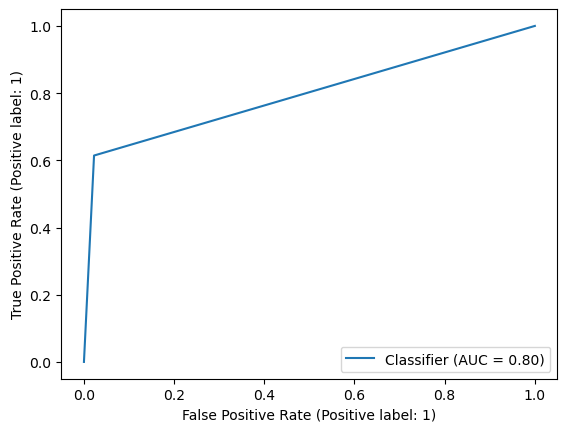

In [15]:
# disp = RocCurveDisplay.from_estimator(nn_model, X_test, y_test)
RocCurveDisplay.from_predictions(y_test, y_test_pred_binary)

### since we are using neural network for better performace we have to do scalling so that weights and bias will not jump too much

In [16]:
def scale_and_save_scaler(X_train_data, scaler_filepath='artifacts/scaler.pkl'):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_data)
    joblib.dump(scaler, scaler_filepath)
    return X_train_scaled

In [17]:
# --- Part 2: Load Scaler and Transform X_test ---

def load_scaler_and_transform_X_test(X_test_data, scaler_filepath='artifacts/scaler.pkl'):
    loaded_scaler = joblib.load(scaler_filepath)
    X_test_scaled = loaded_scaler.transform(X_test_data)
    return X_test_scaled

In [18]:
# 3. Train the Model
# Adjust `epochs`, `batch_size`, and `validation_split` based on your data and computational resources.
# `validation_split` reserves a portion of X_train/y_train for validation during training.
epochs = 5
batch_size = 32

X_train = scale_and_save_scaler(X_train)
X_test = scale_and_save_scaler(X_test)

print(f"\n--- Training the Neural Network Model for {epochs} epochs ---")
# If X_train and y_train are not defined, this will raise a NameError.
# You must have your actual X_train, y_train here.
try:
    start_time = time.time()
    history = nn_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,       # Use 20% of training data for validation during training
        verbose=1,                  # Show training progress (0 for silent, 1 for progress bar, 2 for one line per epoch)
        # class_weight=class_weight_dict  
        # For imbalanced fraud data, consider adding `class_weight` or using `imblearn` for resampling:   
        class_weight={0: 1, 1: (len(y_train) - y_train.sum()) / y_train.sum()} # Example: 'balanced' weight
    )
    print("\nModel training complete.")
    end_time = time.time()

    print(f"Training duration: {(end_time - start_time) / 60:.2f} minutes")
except NameError:
    print("\nSkipping model training: X_train or y_train not found. Please provide your data.")


--- Training the Neural Network Model for 5 epochs ---
Epoch 1/5
25934/25934 [==============================] - 170s 7ms/step - loss: 0.5671 - accuracy: 0.9132 - auc: 0.9443 - val_loss: 0.1602 - val_accuracy: 0.9657 - val_auc: 0.9810
Epoch 2/5
25934/25934 [==============================] - 159s 6ms/step - loss: 0.4024 - accuracy: 0.9336 - auc: 0.9731 - val_loss: 0.1556 - val_accuracy: 0.9489 - val_auc: 0.9828
Epoch 3/5
25934/25934 [==============================] - 160s 6ms/step - loss: 0.3835 - accuracy: 0.9348 - auc: 0.9756 - val_loss: 0.1926 - val_accuracy: 0.9236 - val_auc: 0.9861
Epoch 4/5
25934/25934 [==============================] - 160s 6ms/step - loss: 0.3758 - accuracy: 0.9315 - auc: 0.9765 - val_loss: 0.1399 - val_accuracy: 0.9587 - val_auc: 0.9839
Epoch 5/5
25934/25934 [==============================] - 161s 6ms/step - loss: 0.3721 - accuracy: 0.9316 - auc: 0.9771 - val_loss: 0.1657 - val_accuracy: 0.9353 - val_auc: 0.9848

Model training complete.
Training duration: 13.5

In [19]:
# 4. Evaluate the Model on the Test Set
print("\n--- Evaluating the Neural Network Model on Test Set ---")
# Again, X_test and y_test must be defined in your environment.
try:
    test_loss, test_accuracy, test_auc = nn_model.evaluate(X_test, y_test, verbose=0)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
except NameError:
    print("Skipping model evaluation: X_test or y_test not found. Please provide your data.")


--- Evaluating the Neural Network Model on Test Set ---
Test Loss: 0.1629
Test Accuracy: 0.9317
Test AUC: 0.9849


In [20]:
# 5. Make Predictions
print("\n--- Making Predictions ---")
try:
    # Predict probabilities for the positive class (fraud)
    y_train_pred_proba = nn_model.predict(X_train).flatten()
    y_test_pred_proba = nn_model.predict(X_test).flatten()

    # Convert probabilities to binary predictions using a 0.5 threshold
    y_train_pred_binary = (y_train_pred_proba > 0.5).astype(int)
    y_test_pred_binary = (y_test_pred_proba > 0.5).astype(int)

    # Use your print_score function
    print_score(y_train, y_train_pred_binary, train=True) # Use probabilities for ROC AUC
    print_score(y_test, y_test_pred_binary, train=False) # Use probabilities for ROC AUC

except NameError:
    print("Skipping predictions: X_train, y_train, X_test, or y_test not found. Please provide your data.")


--- Making Predictions ---
8105/8105 [==============================] - 19s 2ms/step
Train Result:
Accuracy Score: 93.50%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0          1.0  accuracy     macro avg  weighted avg
precision  9.995522e-01     0.076785  0.934989  5.381688e-01  9.942105e-01
recall     9.350298e-01     0.928060  0.934989  9.315449e-01  9.349895e-01
f1-score   9.662151e-01     0.141835  0.934989  5.540253e-01  9.614428e-01
support    1.031335e+06  6005.000000  0.934989  1.037340e+06  1.037340e+06
_______________________________________________
Confusion Matrix: 
 [[964329  67006]
 [   432   5573]]

Test Result:
Accuracy Score: 93.17%
_______________________________________________
CLASSIFICATION REPORT:
                       0            1  accuracy      macro avg   weighted avg
precision       0.999542     0.073280  0.931745       0.536411       0.994181
recall          0.931774     0.926716  0.931745       0.929245  

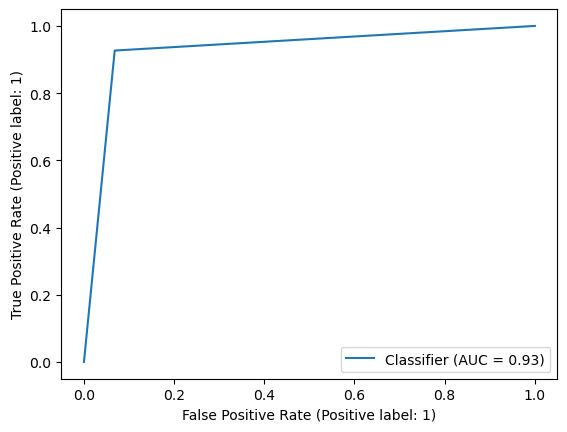

In [21]:
RocCurveDisplay.from_predictions(y_test, y_test_pred_binary)

### since we have highly imbalance dataset we should go with F1 score as evaluation metric
### we are still run few more algorithm and then we will use smote and then re-run same algorithms

# <a id='seventh'></a> Model Evaluation

### Model Evaluation on Test Set
#### Because of the imbalance data, it shows high number of False Positive (confustion metrix for above models)

This code snippet demonstrates how to evaluate the best model selected during the grid search process on the test set. The evaluation metric used here is the 'Accuracy Score', which measures how many correct predictions happened from all predictions.
Thou its not the best one. personally I would go for f1 score.

#### Steps:
1. **Prediction**: 
   - Make predictions on the test set using the best model (`best_model.predict(X_test)`). In this case, we are going with RandomForest.

2. **Accuracy Calculation**:
   - Calculate the Accuracy score using the predicted values and true target values.
   - Accuracy score measures the goodness-of-fit of the model

#### Benefits:
- **Model Generalization Assessment**: The accuracy score on the test set provides insights into how well the model generalizes to unseen data.
- **Performance Communication**: Communicating the accuracy score allows stakeholders to understand the effectiveness of the predictive model.

#### Considerations:
- **Interpretation**: A higher accuracy score indicates better model performance, with values closer to 1 indicating a better fit. However, accuracy should be interpreted in the context of the problem domain and compared to alternative models.

# <a id='eighth'></a> Summary

This This predictive model can be strategically integrated into the Lending Club's operations to enhance decision-making and mitigate risks. Potential applications include:

>`Real-time Transaction Monitoring`
>
>`Customer Behavioral Anomaly Detection`
>
>`Merchant Fraud Prevention`
>
>`Internal Fraud Detection`

#### Continuous improvement and adaptation
Fraud detection can further enhance its operational efficiency, mitigate financial risks, and make more informed decisions, ultimately benefiting both the platform and its users. Continuous improvement and adaptation are key to maximizing the long-term value of this data science initiative.

#### Future scope:
1. **Balance data**: 
   - Target variable(Loan status is highly imbalance)
   - Use SMOTE or
   - Use stratified K fold cross validations for training

2. **Scaler**:
   - So far we have not used any scaler but standard scaler will give better accuracy
   - We can use One hot encoding for categorical features

3. **Dimensionaly reduction**
   - We can implement dimensionaly reduction using PCA for faster convergence of model

4. **Correlations**
   - Features are corelated
   - we can apply L2(ridge) regression for feature selection

5. **More models**
   - we can apply more models and they we can compare those models

6. **Data types**
   - Most of the features data types are Float64, Int64, Int32
   - Categorical features, we can apply Int8
   - Few numerical features, we can apply Float8 such as 'Interest Rate'

7. **Optuna**
   - Instead of grid search, we can use optuna for hyperparameter tuning

8. **SHAP**
   - Implement SHAP for getting more related features thru shap_values

9. **Data drift/ concept drift**
    - Implement stratagies for data drift and/or concept drift

10. **F1 Score**
    - F1 score will be the correct metric to evaluate this problem.
    - I have use accuracy for time being but in version 2, I will implement f1 score

# <a id='ninth'></a> References

[Fraud detections Data](https://www.kaggle.com/code/ambarishdeb/credit-card-fraud-prediction-eda-ml-evaluation/input) - Credit Card Fraud Prediction EDA ML Evaluation

[Google](https://www.google.com) - To get domain knowledge regarding features

[Keggle Notebook](https://www.kaggle.com/code/ambarishdeb/credit-card-fraud-prediction-eda-ml-evaluation/notebook) - Used for some visualization assistance

[HVPlots](https://hvplot.holoviz.org/getting_started/installation.html) - I used hvplots for dynamic graphs